In [23]:
import talib as ta
import numpy as np
import pandas as pd
import yfinance as yf
from talib import abstract
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
from mplfinance.original_flavor import candlestick_ohlc

In [24]:
ticker = input('Enter Ticker Symbol --> ')
start_time = input('Enter Start Time(in yyyy-mm-dd) --> ')
end_time = input('Enter End Time(in yyyy-mm-dd) --> ')
interval_time = input('Enter interval Time(valid intervals :- 1h,1d,5d,1wk,1mo,3mo) --> ')

Enter Ticker Symbol --> AAPL
Enter Start Time(in yyyy-mm-dd) --> 2020-05-01
Enter End Time(in yyyy-mm-dd) --> 2021-06-01
Enter interval Time(valid intervals :- 1h,1d,5d,1wk,1mo,3mo) --> 1D


In [25]:
df = pd.DataFrame()
df = yf.download(ticker, start = start_time, end = end_time, interval = interval_time)
df =  df.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Adj Close': 'close', 'Volume': 'volume'})

df.head()

[*********************100%***********************]  1 of 1 completed


,open,high,low,Close,close,volume
Date,,,,,,
2020-04-30,72.489998,73.632500,72.087502,73.449997,72.761436,183064000
2020-05-01,71.562500,74.750000,71.462502,72.267502,71.590034,240616800
2020-05-04,72.292503,73.422501,71.580002,73.290001,72.602936,133568000
2020-05-05,73.764999,75.250000,73.614998,74.389999,73.692627,147751200
2020-05-06,75.114998,75.809998,74.717499,75.157501,74.452927,142333600


In [26]:
def SMA_fun(df, sma_int, lma_int):   
    df['SMA'] = abstract.SMA(df, sma_int)
    df['LMA'] = abstract.SMA(df, lma_int)

    return(df)

In [27]:
def EMA_fun(df, sma_int, lma_int):
    df['SMA'] = abstract.EMA(df, sma_int)
    df['LMA'] = abstract.EMA(df, lma_int)

    return(df)

In [28]:
def WMA_fun(df, sma_int, lma_int):
    df['SMA'] = abstract.WMA(df, sma_int)
    df['LMA'] = abstract.WMA(df, lma_int)

    return(df)

In [29]:
def DEMA_fun(df, sma_int, lma_int):
    df['SMA'] = abstract.DEMA(df, sma_int)
    df['LMA'] = abstract.DEMA(df, lma_int)

    return(df)

In [30]:
def TEMA_fun(df, sma_int, lma_int):
    df['SMA'] = abstract.TEMA(df, sma_int)
    df['LMA'] = abstract.TEMA(df, lma_int)

    return(df)

In [31]:
def RSI_fun(df):
    df['MI'] = abstract.RSI(df, 14)

    return(df)

In [32]:
def MACD_fun(df):
    temp = abstract.MACD(df, fastperiod=12, slowperiod=26)
    
    df['MI'] = temp['macd']
    df['signal_line'] = temp['macdsignal']
    
    return(df)

In [33]:
def ADX_fun(df):
    df['MI'] = abstract.ADX(df, 14)

    return(df)

In [34]:
def SO_fun(df):
    temp = abstract.STOCHF(df, fastk_period=14)

    df['MI'] = temp['fastk']
    
    return(df)

In [35]:
def WR_fun(df):
    df['MI'] = abstract.WILLR(df, 14)

    return(df)

In [36]:
def strategy(df, lma_int, ind2, stop_loss, stop_profit):
    
    a = df.shape[0]  
    
    temp = df.loc[:, ['SMA', 'LMA', 'MI']].copy()
    Signal =  np.zeros(a)
    
    if ind2 == 'RSI':
        temp['MI_back'] = temp['MI'].shift(5)
        
        i = 0
        for index,row in temp.iterrows():
            if row['SMA'] > row['LMA']:
                if row['MI'] > 40 and row['MI_back'] < 40:
                    Signal[i] = 1
                i += 1
            else:
                if row['MI'] < 60 and row['MI_back'] > 60:
                    Signal[i] = -1
                i += 1
    elif ind2 == 'MACD':
        temp['diff_ms'] = temp['MI'] - df['signal_line']
     
        i = 0
        for index,row in temp.iterrows():
            if row['SMA'] > row['LMA']:
                if row['diff_ms'] > 0:
                    Signal[i] = 1
                i += 1
            else:
                if row['diff_ms'] < 0:
                    Signal[i] = -1
                i += 1
    elif ind2 == 'ADX':
        temp['DI+'] = abstract.PLUS_DI(df, 14)
        temp['DI-'] = abstract.MINUS_DI(df, 14)
        
        i = 0
        for index,row in temp.iterrows():
            if row['SMA'] > row['LMA']:
                if (row['DI+'] > row['DI-']) and row['MI'] > 21:
                    Signal[i] = 1
                i += 1
            else:
                if (row['DI+'] < row['DI-']) and row['MI'] > 21:
                    Signal[i] = -1
                i += 1
    elif ind2 == 'SO':
        temp['MI_back'] = temp['MI'].shift(5)
        
        i = 0
        for index,row in temp.iterrows():
            if row['SMA'] > row['LMA']:
                if row['MI'] > 20 and row['MI_back'] < 20:
                    Signal[i] = 1
                i += 1
            else:
                if row['MI'] < 80 and row['MI_back'] > 80:
                    Signal[i] = -1
                i += 1
    else:
        temp['MI_back'] = temp['MI'].shift(5)
        
        i = 0
        for index,row in temp.iterrows():
            if row['SMA'] > row['LMA']:
                if row['MI'] < -80 and row['MI_back'] > -80:
                    Signal[i] = 1
                i += 1
            else:
                if row['MI'] > -20 and row['MI_back'] < -20:
                    Signal[i] = -1
                i += 1

    df['signal'] = Signal
        
    Order = np.zeros(a)
  
    prev_inv = 0
    prev_sig = 0
    i = 0
    for index,row in df.iterrows():
        if row['signal'] == 1 and prev_sig != 1:
            prev_sig = 1
            
            prev_inv = row['open']
            
            Order[i] = prev_sig

            i += 1
        elif row['signal'] == -1 and prev_sig != -1:
            prev_sig = -1

            Order[i] = prev_sig

            i += 1
        else:
            if prev_inv != 0:
                pl = ((row['open'] - prev_inv)/prev_inv)*100
            
                if pl > stop_profit and prev_sig == 1:
                    prev_signal = -1
                
                    Order[i] = prev_sig
                elif pl < stop_loss and prev_sig == 1:
                    prev_signal = -1
                
                    Order[i] = prev_sig
                
            i += 1
            
        
    df['order'] = Order

    df = df.iloc[lma_int:].copy()

    return(df)

In [37]:
def backtesting(df, no_of_contracts, capital):
    a = df.shape
 
    Total = np.zeros(a[0])
    end_pos = np.zeros(a[0])
    invested = np.zeros(a[0])

    i = 0 
    prev_invest = 0
    prev_end = 0
    for index, row in df.iterrows():
        if row['order'] == 1:
            Total[i] = capital - (no_of_contracts*row['open'])
            capital = Total[i]

            prev_invest = row['open']
            invested[i] = prev_invest

            prev_end = 1
            end_pos[i] = prev_end 

            i += 1
      
        elif row['order'] == -1:
            Total[i] = capital + (no_of_contracts*row['open'])
            capital = Total[i]

            prev_invest = 0

            prev_end = 0
            end_pos[i] = prev_end

            i += 1
        else:
            Total[i] = capital 
  
            invested[i] = prev_invest

            end_pos[i] = prev_end
    
            i += 1

    df['total'] = Total
    df['holdings'] = df['total'] + (end_pos*no_of_contracts*df['open'])
  
    Returns = np.zeros(a[0])

    i = 0 
    prev_return = 0
    for index, row in df.iterrows():
        if end_pos[i] == 1:
            prev_return = ((no_of_contracts*(row['open'] - invested[i]))/invested[i])
            Returns[i] = prev_return

            i += 1
        else:
            Returns[i] = prev_return
      
            i += 1

    df['returns'] = Returns 

    return(df)

In [38]:
print('MOVING AVERAGES')
print('Simple Moving Average = SMA')
print('Exponential Moving Average = EMA')
print('Weighted Moving Average = WMA')
print('Double Exponential Moving Average = DEMA')
print('Triple Exponential Moving Average = TEMA')


print('\n')
print('MOMENTUM INDICATORS')
print('Relative Strength Index = RSI')
print('Moving Average Convergence Divergence = MACD')
print('Average Directional Movement Index = ADX')
print('Stochastic Oscillator = SO')
print('Williams %R = WR\n')

MOVING AVERAGES
Simple Moving Average = SMA
Exponential Moving Average = EMA
Weighted Moving Average = WMA
Double Exponential Moving Average = DEMA
Triple Exponential Moving Average = TEMA


MOMENTUM INDICATORS
Relative Strength Index = RSI
Moving Average Convergence Divergence = MACD
Average Directional Movement Index = ADX
Stochastic Oscillator = SO
Williams %R = WR



In [39]:
ind1 = input('CHOOSE A MOVING AVERAGE --> ')
sma_int = int(input('Enter Short Moving Average Interval --> '))
lma_int = int(input('Enter Long Moving Average Interval --> '))

if ind1 == 'SMA':
    df = SMA_fun(df, sma_int, lma_int)
elif ind1 == 'EMA':
    df = EMA_fun(df, sma_int, lma_int)
elif ind1 == 'WMA':
    df = WMA_fun(df, sma_int, lma_int)
elif ind1 == 'DEMA':
    df = DEMA_fun(df, sma_int, lma_int)
else:
    df = TEMA_fun(df, sma_int, lma_int)

print('\n')
ind2 = input('CHOOSE MOMENTUM INDICATOR --> ')

if ind2 == 'RSI':
    df = RSI_fun(df)
elif ind2 == 'MACD':
    df = MACD_fun(df)
elif ind2 == 'ADX':
    df = ADX_fun(df)
elif ind2 == 'SO':
    df = SO_fun(df)
else:
    df = WR_fun(df)
    
print('\n')
no_of_contracts = int(input('Enter number of shares you want to buy --> '))
capital = float(input('Enter Amount of capital you currently hold --> '))

print('\n')
stop_loss = float(input('Enter Stop Loss(in %) --> '))
stop_profit = float(input('Enter Stop Profit(in %) --> '))

df = strategy(df, lma_int, ind2, stop_loss, stop_profit)
df = backtesting(df, no_of_contracts, capital)

CHOOSE A MOVING AVERAGE --> EMA
Enter Short Moving Average Interval --> 3
Enter Long Moving Average Interval --> 40


CHOOSE MOMENTUM INDICATOR --> ADX


Enter number of shares you want to buy --> 3
Enter Amount of capital you currently hold --> 1000000000


Enter Stop Loss(in %) --> 0.2
Enter Stop Profit(in %) --> 5


In [40]:
df.tail(1)

,open,high,low,Close,close,volume,SMA,LMA,MI,signal,order,total,holdings,returns
Date,,,,,,,,,,,,,,
2021-05-28,125.57,125.800003,124.550003,124.610001,124.610001,71311100,125.3163,127.527513,17.706931,0.0,0.0,9.999710e+08,9.999710e+08,-0.116069


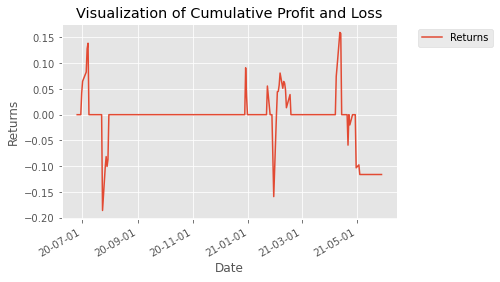

In [41]:
plt.style.use('ggplot')

fig, ax = plt.subplots()
plt.plot(df['returns'], label="Returns")
ax.xaxis_date()
ax.set_xlabel('Date')
ax.set_ylabel('Returns')
ax.set_title('Visualization of Cumulative Profit and Loss')
myFmt = mpl_dates.DateFormatter('%y-%m-%d')
ax.xaxis.set_major_formatter(myFmt)
fig.autofmt_xdate()
plt.legend(loc=2, bbox_to_anchor=(1.05, 1)) 

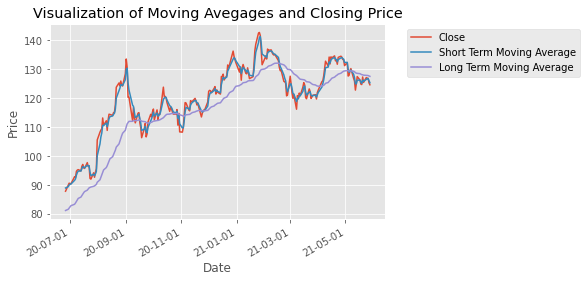

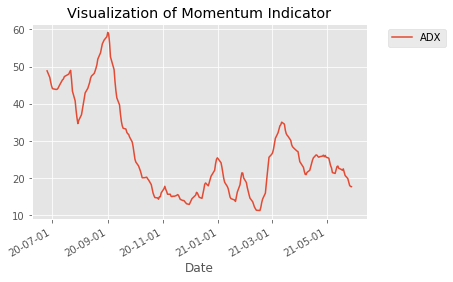

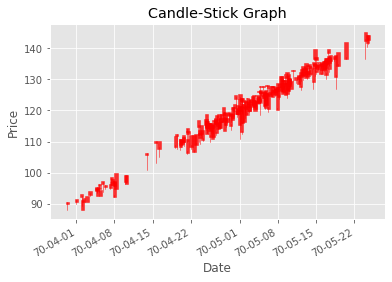

In [42]:
plt.style.use('ggplot')

fig1, ax1 = plt.subplots()
plt.plot(df['close'], label="Close")
plt.plot(df['SMA'], label="Short Term Moving Average")
plt.plot(df['LMA'], label="Long Term Moving Average")
ax1.xaxis_date()
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.set_title('Visualization of Moving Avegages and Closing Price')
myFmt = mpl_dates.DateFormatter('%y-%m-%d')
ax1.xaxis.set_major_formatter(myFmt)
fig1.autofmt_xdate()
plt.legend(loc=2, bbox_to_anchor=(1.05, 1)) 

print('\n')
fig2, ax2 = plt.subplots()
plt.plot(df['MI'], label=ind2)
ax2.xaxis_date('Momentum Indicator')
ax2.set_xlabel('Date')
ax2.set_ylabel('')
ax2.set_title('Visualization of Momentum Indicator')
myFmt = mpl_dates.DateFormatter('%y-%m-%d')
ax2.xaxis.set_major_formatter(myFmt)
fig2.autofmt_xdate()
plt.legend(loc=2, bbox_to_anchor=(1.05, 1)) 

print('\n')
fig3, ax3 = plt.subplots()
candlestick_ohlc(ax3, df.values, width=0.6, colorup='green', colordown='red', alpha=0.8)
ax3.xaxis_date()
ax3.set_xlabel('Date')
ax3.set_ylabel('Price')
ax3.set_title('Candle-Stick Graph')
myFmt = mpl_dates.DateFormatter('%y-%m-%d')
ax3.xaxis.set_major_formatter(myFmt)
fig3.autofmt_xdate()

plt.show()